In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lbg_forecast.nz_model as nz
from lbg_forecast.nz_model import NzModel

In [2]:
def gather_redshifts(nfiles, path):
    i = 0
    nz_data = []
    while(i < nfiles):
        nzs = np.load(path+"redshifts/emulated_redshifts_"+str(i)+".npy", allow_pickle=True)
        nsamples = nzs.shape[0]
        j = 0
        while(j < nsamples):
            nz_data.append(nzs[j, :])
            j+=1
        i+=1

    return np.asarray(nz_data)

In [3]:
#convert histogram to function (old code - slow)
def pdf(z, hist):
    
    bin_l = len(hist[1])
    pdf_l = len(hist[0]) #(bin_l - 1)
    
    bin_list = hist[1]
    pdf_list = hist[0]
    bin_no = 0
    
    for binn in bin_list:
        if(bin_no >= pdf_l):
            break
        if(binn > z):
            break
        bin_no+=1
    
    bin_no = bin_no-1
    if(bin_no > 0 or bin_no < bin_l):
        return pdf_list[bin_no]
    else:
        return 0.0
    
def get_zgrid_for_bins(hist_bins, factor):

    bins_start = hist_bins[0]
    bins_end = hist_bins[-1]

    z_list = np.linspace(bins_start, bins_end, len(hist_bins)*factor)

    return z_list

#over sample by factor of 10
def convert_hist_to_pdf(hist, factor):
        
        z_list = get_zgrid_for_bins(hist[1], factor)
        pdf_list = []
        for z in z_list:
            pdf_list.append(pdf(z, hist))

        #plt.plot(z_list, pdf_list)
        
        return (z_list, pdf_list)

#very slow!!!
def process_redshifts(nzs, bin_size, factor, path):
     
    dz = bin_size
    minz = 0.0
    maxz = 7.0
    bins = np.arange(minz, maxz+dz, dz)

    dropout = 0
    sample = 0
    nsamples = nzs.shape[0]
    newnzs = np.empty(3, dtype=object)
    while(dropout < 3):
        dropouts = []
        sample = 0
        while(sample < nsamples):
            nzhist = np.histogram(nzs[sample, dropout], density=True, bins=bins)
            dropouts.append(convert_hist_to_pdf(nzhist, factor)[1])
            sample+=1
        dropouts = np.asarray(dropouts)
        newnzs[dropout] = dropouts
        dropout+=1
    
    z_grid = get_zgrid_for_bins(bins, factor)
    np.save(path+"redshifts/nzus.npy", newnzs[0])
    np.save(path+"redshifts/nzgs.npy", newnzs[1])
    np.save(path+"redshifts/nzrs.npy", newnzs[2])
    np.save(path+"redshifts/z_grid.npy", z_grid)

    return z_grid, newnzs
               


In [4]:
nzs = gather_redshifts(1, path="./")
total_nzs = len(nzs)
print("total nzs:", total_nzs)

total nzs: 128


In [5]:
z_grid, nz_pdfs = process_redshifts(nzs, 0.2, 50, path="./")

In [6]:
nzmodel = NzModel(path="./")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


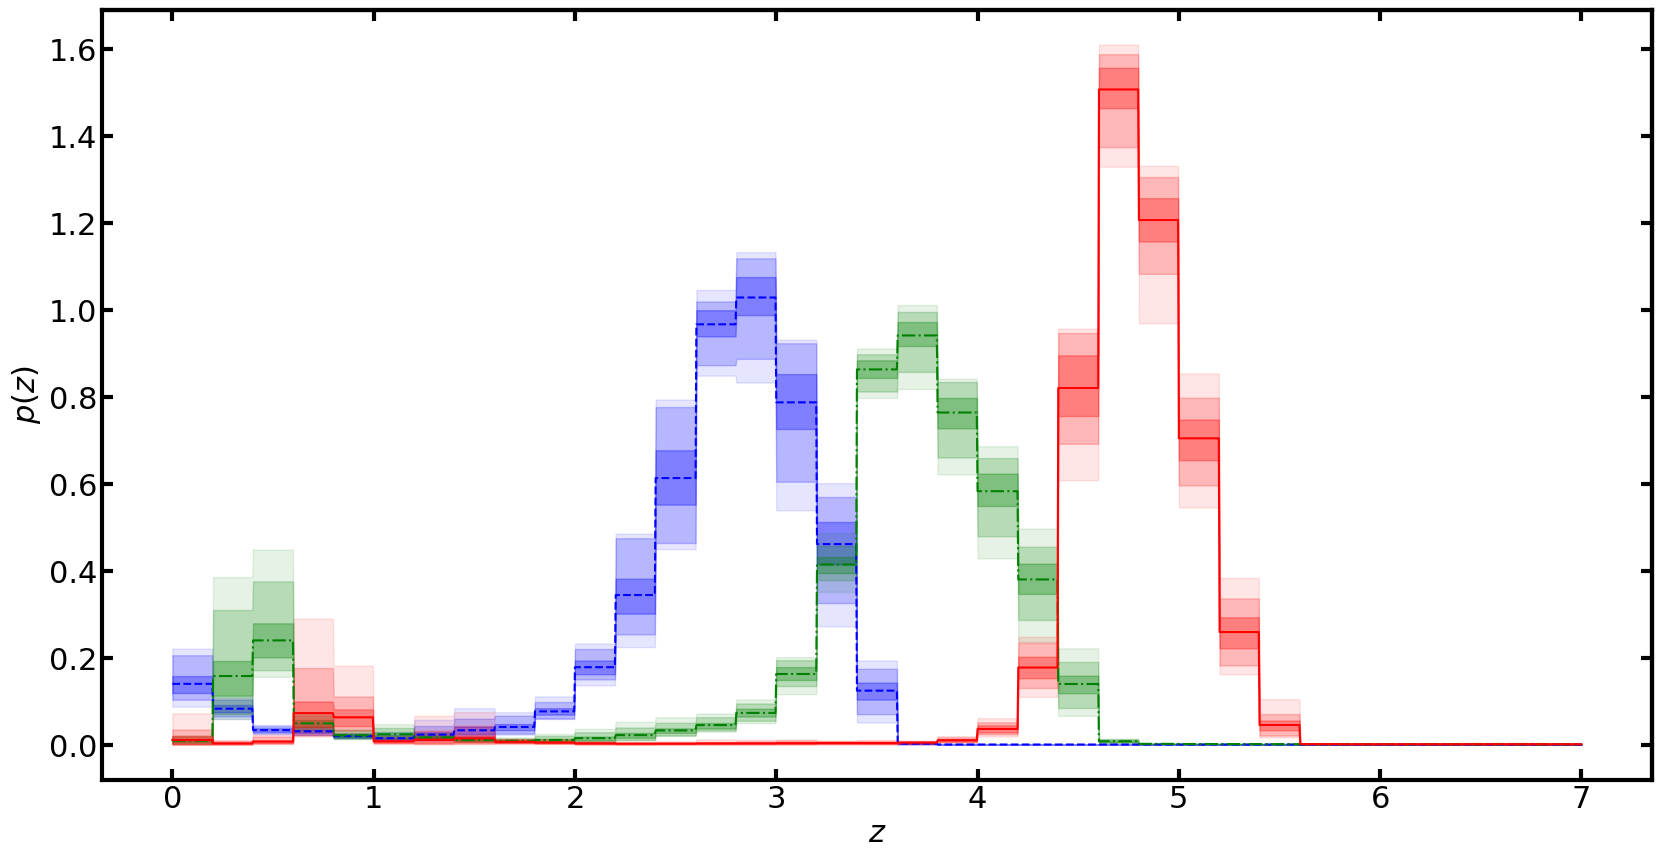

In [7]:
nzmodel.plot_all_data()

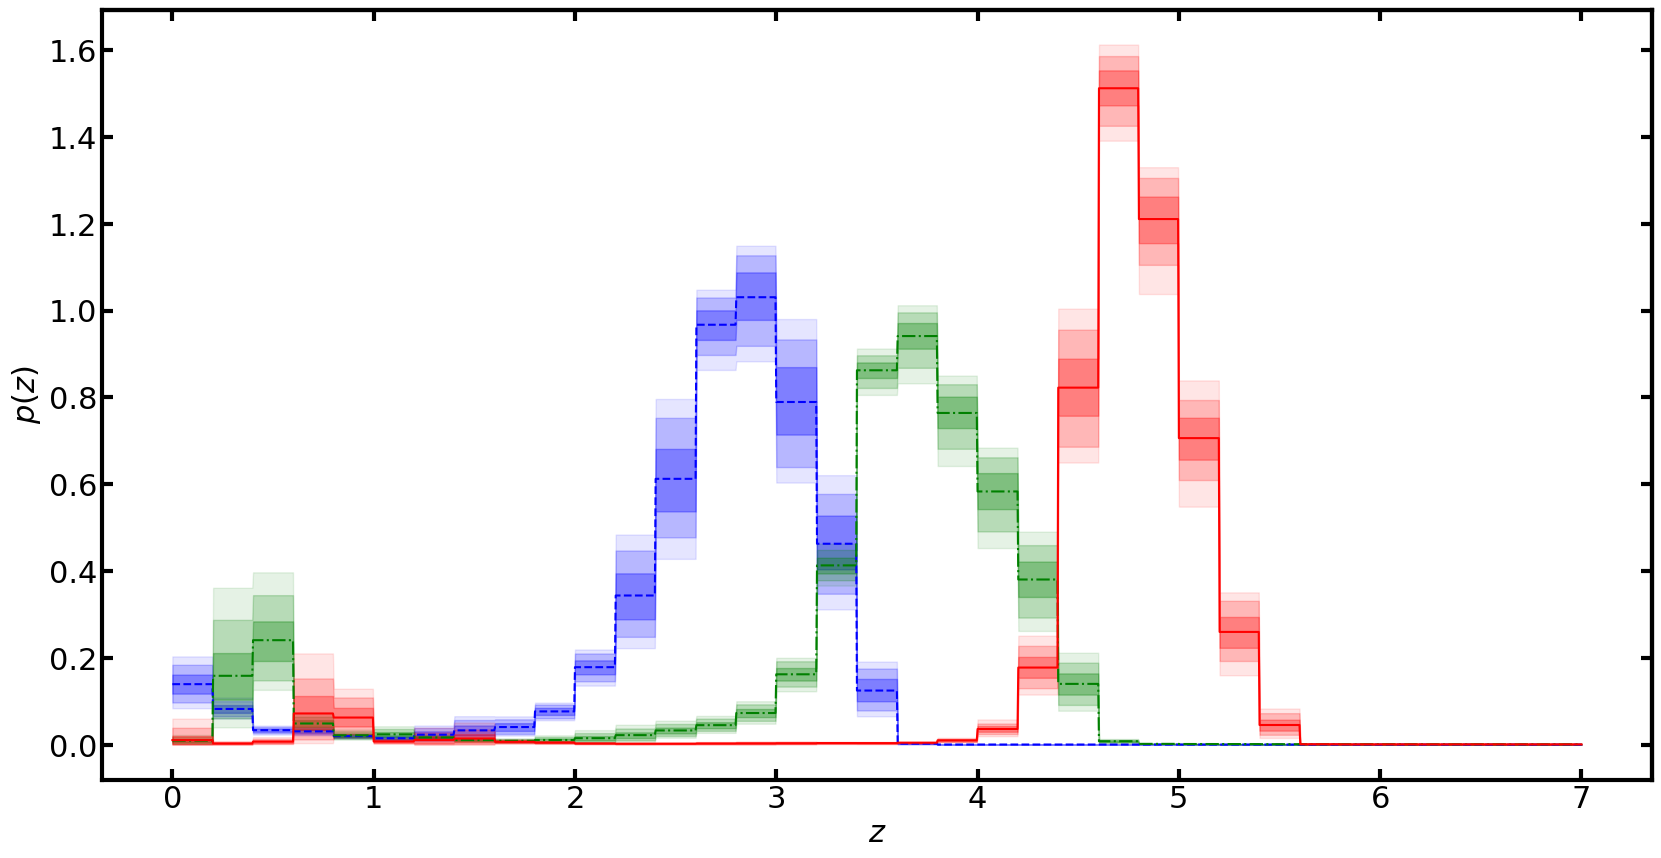

In [8]:
nzmodel.plot_all_pca(4, 1000)

In [9]:
nzmodel.save_4pca_data("./")
nzmodel.save_12pca_data("./")